<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自然語言處理(NLP,Nature Language Process)
指的是一些與自然語言相關的計算技術

# 單詞雲 (word clouds)
根據單詞出現的次數，來決定字體的大小。

In [2]:
data = [("big data",100,15),("Hadoop",95,25),("Python",75,50),("R",50,40),("machine learning",80,20),("statistics",20,60),("data science",60,70),("analytics",90,3),("team player",85,85),("dynamic",2,90),("synergies",70,0),("actionable insights",40,30),("think out of box",45,10),("self-starter",30,50),("customer focus",65,15),("thought leadership",35,35)]

### 圖 21-1 一個由流行語所組成的單詞雲

### 圖 21-2 一個較有意義的單詞雲

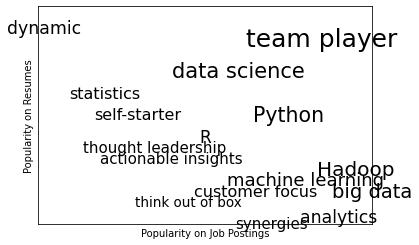

In [3]:
from matplotlib import pyplot as plt

def text_size(total:int) ->float:
  """如果total是0就送出8，如果total是200就送出28"""
  return 8+total/200*20

for word,job_popularity,resume_popularity in data:
  plt.text(job_popularity,resume_popularity,word,ha="center",va="center",size=text_size(job_popularity+resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100,0,100])
plt.xticks([])
plt.yticks([])
plt.show()

# N-gram 語言模型

## 2-gram (bigram)
1. 針對某個起始單詞，查出原始文件中皆在這個單詞後面的所有單詞
2. 自其中隨機選擇一個做為下一個單詞
3. 重複這個動作(1. 2.)直到選中代表句子結束的句號。

## 3-gram (trigram)

# 文法

# Gibbs 取樣

# 主題模型化

# 單詞向量

# RNN遞迴神經網路

## 字元級RNN